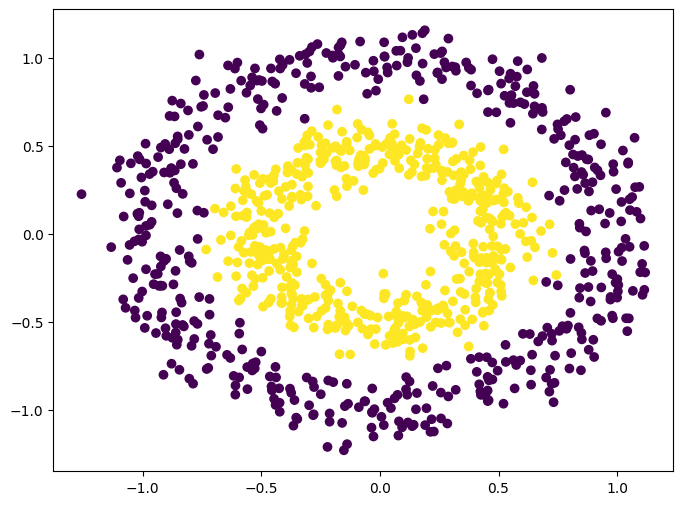

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score

tf.random.set_seed(42)
np.random.seed(42)

# Make data: Two circles on x-y plane as a classification problem
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1)
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()



In [37]:
# Test performance with 3-layer binary classification network
model = Sequential([
    Input(shape=(2,)),
    Dense(5, "relu"),
    Dense(1, "sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X, y, batch_size=32, epochs=100, verbose=0)
print(model.evaluate(X,y))



32/32 [==============================] - 0s 336us/step - loss: 0.3082 - acc: 0.9430
[0.3082215189933777, 0.9430000185966492]


In [38]:
# Test performance with 3-layer network with sigmoid activation
model = Sequential([
    Input(shape=(2,)),
    Dense(5, "sigmoid"),
    Dense(1, "sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X, y, batch_size=32, epochs=100, verbose=0)
print(model.evaluate(X,y))



32/32 [==============================] - 0s 351us/step - loss: 0.6841 - acc: 0.6620
[0.6841325163841248, 0.6620000004768372]


In [39]:
# Test performance with 5-layer network with sigmoid activation
model = Sequential([
    Input(shape=(2,)),
    Dense(5, "sigmoid"),
    Dense(5, "sigmoid"),
    Dense(5, "sigmoid"),
    Dense(1, "sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X, y, batch_size=32, epochs=100, verbose=0)
print(model.evaluate(X,y))



32/32 [==============================] - 0s 351us/step - loss: 0.6917 - acc: 0.5000
[0.6916907429695129, 0.5]


In [2]:
# Illustrate weights across epochs
class WeightCapture(Callback):
    "Capture the weights of each layer of the model"
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.weights = []
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch) # remember the epoch axis
        weight = {}
        for layer in model.layers:
            if not layer.weights:
                continue
            name = layer.weights[0].name.split("/")[0]
            weight[name] = layer.weights[0].numpy()
        self.weights.append(weight)

def make_mlp(activation, initializer, name):
    "Create a model with specified activation and initalizer"
    model = Sequential([
        Input(shape=(2,), name=name+"0"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"1"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"2"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"3"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"4"),
        Dense(1, activation="sigmoid", kernel_initializer=initializer, name=name+"5")
    ])
    return model


In [3]:
def plotweight(capture_cb):
    "Plot the weights' mean and s.d. across epochs"
    fig, ax = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8, 10))
    ax[0].set_title("Mean weight")
    for key in capture_cb.weights[0]:
        ax[0].plot(capture_cb.epochs, [w[key].mean() for w in capture_cb.weights], label=key)
    ax[0].legend()
    ax[1].set_title("S.D.")
    for key in capture_cb.weights[0]:
        ax[1].plot(capture_cb.epochs, [w[key].std() for w in capture_cb.weights], label=key)
    ax[1].legend()
    plt.show()

In [4]:
initializer = RandomNormal(mean=0, stddev=1)
batch_size = 1
n_epochs = 100

2024-02-03 18:03:35.427732: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-03 18:03:35.427801: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-03 18:03:35.427813: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-03 18:03:35.427857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-03 18:03:35.427876: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/smudge/Desktop/Code/Uni/Deep-Learning/.venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being

Before training: Accuracy 0.491


2024-02-03 18:03:36.369344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


After training: Accuracy 0.987
32/32 [==============================] - 1s 6ms/step - loss: 0.0369 - acc: 0.9870
[0.036851413547992706, 0.9869999885559082]


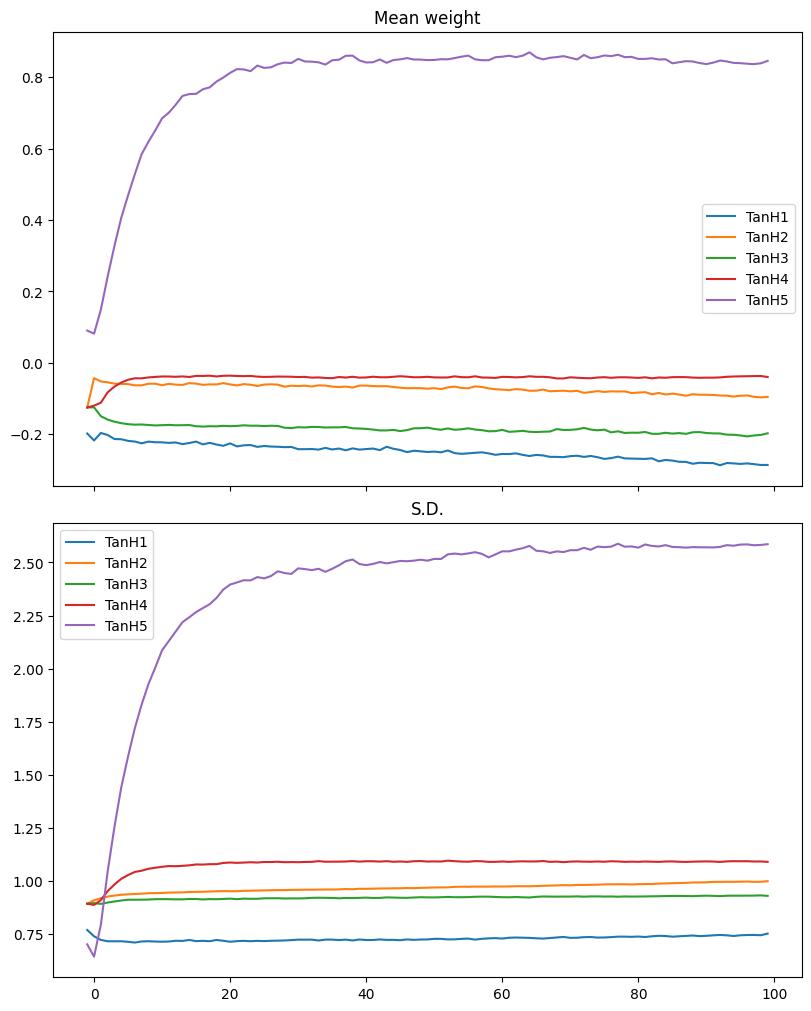

In [5]:
# Sigmoid activation
model = make_mlp("tanh", initializer, "TanH")
capture_cb = WeightCapture(model)
capture_cb.on_epoch_end(-1)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
print("Before training: Accuracy", accuracy_score(y, (model(X).numpy() > 0.5).astype(int)))
model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[capture_cb], verbose=0)
print("After training: Accuracy", accuracy_score(y, (model(X).numpy() > 0.5).astype(int)))
print(model.evaluate(X,y))
plotweight(capture_cb)